### Implementing PMFs

Copyright 2019 Allen Downey

BSD 3-clause license: https://opensource.org/licenses/BSD-3-Clause

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt

In [2]:
import inspect

def psource(obj):
    """Prints the source code for a given object.

    obj: function or method object
    """
    print(inspect.getsource(obj))

### Constructor

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/1).

The `Pmf` class inherits from `pd.Series`.  The `__init__` method is essentially unchanged, but it includes a workaround for what I think is bad behavior.

In [3]:
from empyrical_dist import Pmf

psource(Pmf.__init__)

    def __init__(self, *args, **kwargs):
        """Initialize a Pmf.

        Note: this cleans up a weird Series behavior, which is
        that Series() and Series([]) yield different results.
        See: https://github.com/pandas-dev/pandas/issues/16737
        """
        if args or ('index' in kwargs):
            super().__init__(*args, **kwargs)
        else:
            underride(kwargs, dtype=np.float64)
            super().__init__([], **kwargs)



You can create an empty `Pmf` and then add elements.

Here's a `Pmf` that represents a six-sided die.

In [4]:
d6 = Pmf()

In [5]:
for x in [1,2,3,4,5,6]:
    d6[x] = 1

Initially the probabilities don't add up to 1.

In [6]:
d6

,probs
1,1
2,1
3,1
4,1
5,1
6,1


`normalize` adds up the probabilities and divides through.  The return value is the total probability before normalizing.

In [7]:
psource(Pmf.normalize)

    def normalize(self):
        """Make the probabilities add up to 1 (modifies self).

        :return: normalizing constant
        """
        total = self.sum()
        self /= total
        return total



In [8]:
d6.normalize()

6

Now the Pmf is normalized.

In [9]:
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


### Properties

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/2).

In a `Pmf` the index contains the quantities (`qs`) and the values contain the probabilities (`ps`).

These attributes are available as properties that return arrays (same semantics as the Pandas `values` property)

In [10]:
d6.qs

array([1, 2, 3, 4, 5, 6])

In [11]:
d6.ps

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

### Sharing

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/3).

Because `Pmf` is a `Series` you can initialize it with any type `Series.__init__` can handle.

Here's an example with a dictionary.

In [12]:
d = dict(a=1, b=2, c=3)
pmf = Pmf(d)
pmf

,probs
a,1
b,2
c,3


Here's an example with two lists.

In [13]:
qs = [1,2,3,4]
ps = [0.25, 0.25, 0.25, 0.25]
d4 = Pmf(ps, index=qs)
d4

,probs
1,0.25
2,0.25
3,0.25
4,0.25


You can copy a `Pmf` like this.

In [14]:
d6_copy = Pmf(d6)
d6_copy

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


However, you have to be careful about sharing.  In this example, the copies share the arrays:

In [15]:
d6.index is d6_copy.index

True

In [16]:
d6.ps is d6_copy.ps

True

You can avoid sharing with `copy=True`

In [17]:
d6_copy = Pmf(d6, copy=True)
d6_copy

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [18]:
d6.index is d6_copy.index

False

In [19]:
d6.ps is d6_copy.ps

False

Or by calling `copy` explicitly.

In [20]:
d4_copy = d4.copy()
d4_copy

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [21]:
d4.index is d4_copy.index

False

In [22]:
d4.ps is d4_copy.ps

False

### Displaying PMFs

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/4).

`Pmf` provides `_repr_html_`, so it looks good when displayed in a notebook.

In [23]:
psource(Pmf._repr_html_)

    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()



`Pmf` provides `bar`, which plots the Pmf as a bar chart.

In [24]:
psource(Pmf.bar)

    def bar(self, **options):
        """Makes a bar plot.

        options: passed to plt.bar
        """
        underride(options, label=self.name, color="C1")
        plt.bar(self.qs, self.ps, **options)



In [25]:
def decorate_dice(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('PMF')
    plt.title(title)

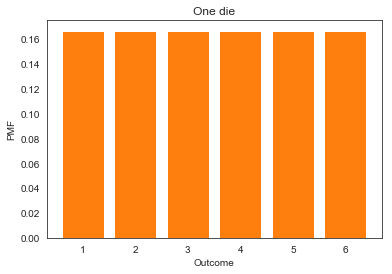

In [26]:
d6.bar()
decorate_dice('One die')

`Pmf` inherits `plot` from `Series`.

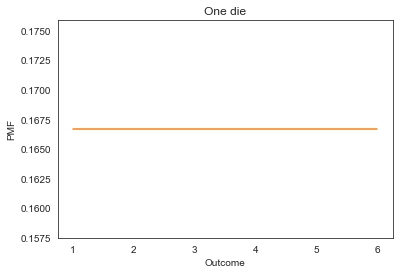

In [27]:
d6.plot()
decorate_dice('One die')

### Make Pmf from sequence

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/5).


The following function makes a `Pmf` object from a sequence of values.

In [28]:
psource(Pmf.from_seq)

    @staticmethod
    def from_seq(seq, normalize=True, sort=True, **options):
        """Make a PMF from a sequence of values.

        seq: any kind of sequence
        normalize: whether to normalize the Pmf, default True
        sort: whether to sort the Pmf by values, default True
        options: passed to the pd.Series constructor

        :return: Pmf object
        """
        series = pd.Series(seq).value_counts(sort=False)

        options["copy"] = False
        pmf = Pmf(series, **options)

        if sort:
            pmf.sort_index(inplace=True)

        if normalize:
            pmf.normalize()

        return pmf



In [29]:
pmf = Pmf.from_seq(list('allen'))
pmf

,probs
a,0.2
e,0.2
l,0.4
n,0.2


In [30]:
pmf = Pmf.from_seq(np.array([1, 2, 2, 3, 5]))
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


### Selection

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/6).

`Pmf` overrides `__getitem__` to return 0 for values that are not in the distribution.

In [31]:
psource(Pmf.__getitem__)

    def __getitem__(self, qs):
        """Look up qs and return ps."""
        try:
            return super().__getitem__(qs)
        except (KeyError, ValueError, IndexError):
            return 0



In [32]:
d6[1]

0.16666666666666666

In [33]:
d6[6]

0.16666666666666666

In [34]:
d6[7]

0

`Pmf` objects are mutable, but in general the result is not normalized.

In [35]:
d6[7] = 1/6
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667
7,0.166667


In [36]:
d6.sum()

1.1666666666666665

In [37]:
d6.normalize()

1.1666666666666665

In [38]:
d6.sum()

1.0000000000000002

### Statistics

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/7).

`Pmf` overrides the statistics methods to compute `mean`, `median`, etc.

These functions only work correctly if the `Pmf` is normalized.

In [39]:
psource(Pmf.mean)

    def mean(self):
        """Computes expected value.

        :return: float
        """
        # TODO: error if not normalized
        # TODO: error if the quantities are not numeric
        return np.sum(self.ps * self.qs)



In [40]:
d6.mean()

4.000000000000001

In [41]:
psource(Pmf.var)

    def var(self):
        """Variance of a PMF.

        :return: float
        """
        m = self.mean()
        d = self.qs - m
        return np.sum(d ** 2 * self.ps)



In [42]:
d6.var()

4.0

In [43]:
psource(Pmf.std)

    def std(self):
        """Standard deviation of a PMF.

        :return: float
        """
        return np.sqrt(self.var())



In [44]:
d6.std()

2.0

### Sampling

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/8).

`choice` chooses a random values from the Pmf, following the API of `np.random.choice`

In [45]:
psource(Pmf.choice)

    def choice(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `p` is provided.

        args: same as np.random.choice
        kwargs: same as np.random.choice

        :return: NumPy array
        """
        underride(kwargs, p=self.ps)
        return np.random.choice(self.qs, *args, **kwargs)



In [46]:
d6.choice(size=10)

array([6, 1, 4, 5, 7, 7, 5, 1, 4, 1])

`sample` chooses a random values from the `Pmf`, following the API of `pd.Series.sample`

In [47]:
psource(Pmf.sample)

    def sample(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `weights` is provided.

        This function returns an array containing a sample of the quantities in this Pmf,
        which is different from Series.sample, which returns a Series with a sample of
        the rows in the original Series.

        args: same as Series.sample
        options: same as Series.sample

        :return: NumPy array
        """
        series = pd.Series(self.qs)
        underride(kwargs, weights=self.ps)
        sample = series.sample(*args, **kwargs)
        return sample.values



In [48]:
d6.sample(n=10, replace=True)

array([5, 4, 5, 4, 5, 3, 1, 7, 5, 5])

### Arithmetic

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/9).

`Pmf` provides `add_dist`, which computes the distribution of the sum.

The implementation uses outer products to compute the convolution of the two distributions.

In [49]:
psource(Pmf.add_dist)

    def add_dist(self, x):
        """Computes the Pmf of the sum of values drawn from self and x.

        x: Distribution, scalar, or sequence

        :return: new Pmf
        """
        if isinstance(x, Distribution):
            return self.convolve_dist(x, np.add.outer)
        else:
            return Pmf(self.ps, index=self.qs + x)



In [50]:
psource(Pmf.convolve_dist)

    def convolve_dist(self, dist, ufunc):
        """Convolve two distributions.

        dist: Distribution
        ufunc: elementwise function for arrays

        :return: new Pmf
        """
        if not isinstance(dist, Pmf):
            dist = dist.make_pmf()

        qs = ufunc(self.qs, dist.qs).flatten()
        ps = np.multiply.outer(self.ps, dist.ps).flatten()
        series = pd.Series(ps).groupby(qs).sum()

        return Pmf(series)



Here's the distribution of the sum of two dice.

In [53]:
d6 = Pmf.from_seq([1,2,3,4,5,6])

twice = d6.add_dist(d6)
twice

,probs
2,0.027778
3,0.055556
4,0.083333
5,0.111111
6,0.138889
7,0.166667
8,0.138889
9,0.111111
10,0.083333
11,0.055556


6.999999999999998

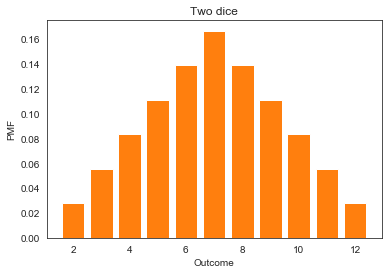

In [54]:
twice.bar()
decorate_dice('Two dice')
twice.mean()

To add a constant to a distribution, you could construct a deterministic `Pmf`

In [55]:
const = Pmf.from_seq([1])
d4.add_dist(const)

,probs
2,0.25
3,0.25
4,0.25
5,0.25


But `add_dist` also handles constants as a special case:

In [56]:
d4.add_dist(1)

,probs
2,0.25
3,0.25
4,0.25
5,0.25


Other arithmetic operations are also implemented

In [57]:
d6.sub_dist(d4)

,probs
-3,0.041667
-2,0.083333
-1,0.125000
0,0.166667
1,0.166667
2,0.166667
3,0.125000
4,0.083333
5,0.041667


In [58]:
d4.mul_dist(d4)

,probs
1,0.0625
2,0.1250
3,0.1250
4,0.1875
6,0.1250
8,0.1250
9,0.0625
12,0.1250
16,0.0625


In [59]:
d4.div_dist(d4)

,probs
0.250000,0.0625
0.333333,0.0625
0.500000,0.1250
0.666667,0.0625
0.750000,0.0625
1.000000,0.2500
1.333333,0.0625
1.500000,0.0625
2.000000,0.1250
3.000000,0.0625


### Comparison operators

`Pmf` implements comparison operators that return probabilities.

You can compare a `Pmf` to a scalar:

In [60]:
d6.lt_dist(3)

0.3333333333333333

In [61]:
d4.ge_dist(2)

0.75

Or compare `Pmf` objects:

In [62]:
d4.gt_dist(d6)

0.25

In [63]:
d6.le_dist(d4)

0.41666666666666663

In [64]:
d4.eq_dist(d6)

0.16666666666666666

Interestingly, this way of comparing distributions is [nontransitive]().

In [65]:
A = Pmf.from_seq([2, 2, 4, 4, 9, 9])
B = Pmf.from_seq([1, 1, 6, 6, 8, 8])
C = Pmf.from_seq([3, 3, 5, 5, 7, 7])

In [66]:
A.gt_dist(B)

0.5555555555555556

In [67]:
B.gt_dist(C)

0.5555555555555556

In [68]:
C.gt_dist(A)

0.5555555555555556

### Joint distributions

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/10).

`Pmf.make_joint` takes two `Pmf` objects and makes their joint distribution, assuming independence.

In [69]:
psource(Pmf.make_joint)

    def make_joint(self, other, **options):
        """Make joint distribution (assuming independence).

        :param self:
        :param other:
        :param options: passed to Pmf constructor

        :return: new Pmf
        """
        qs = pd.MultiIndex.from_product([self.qs, other.qs])
        ps = np.multiply.outer(self.ps, other.ps).flatten()
        return Pmf(ps, index=qs, **options)



In [70]:
d4 = Pmf.from_seq(range(1,5))
d4

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [71]:
d6 = Pmf.from_seq(range(1,7))
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [72]:
joint = Pmf.make_joint(d4, d6)
joint

1  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
2  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
3  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
4  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
dtype: float64

The result is a `Pmf` object that uses a MultiIndex to represent the values.

In [73]:
joint.index

MultiIndex(levels=[[1, 2, 3, 4], [1, 2, 3, 4, 5, 6]],
           codes=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

If you ask for the `qs`, you get an array of pairs:

In [74]:
joint.qs

array([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2),
       (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4),
       (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)],
      dtype=object)

You can select elements using tuples:

In [75]:
joint[1,1]

0.041666666666666664

You can get unnnormalized conditional distributions by selecting on different axes:

In [76]:
Pmf(joint[1])

,probs
1,0.041667
2,0.041667
3,0.041667
4,0.041667
5,0.041667
6,0.041667


In [77]:
Pmf(joint.loc[:, 1])

,probs
1,0.041667
2,0.041667
3,0.041667
4,0.041667


But `Pmf` also provides `conditional(i,j,val)` which returns the distribution along axis `i` conditioned on the value of axis `j`: 

In [78]:
joint.conditional(0, 1, 1)

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [79]:
joint.conditional(1, 0, 1)

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


It also provides `marginal(i)`, which returns the marginal distribution along axis `i`

In [80]:
joint.marginal(0)

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [81]:
joint.marginal(1)

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


The implementations of `conditional` and `marginal` are simple, but could be made more efficient using Pandas methods.

In [82]:
psource(Pmf.conditional)

    def conditional(self, i, j, val, name=None):
        """Gets the conditional distribution of the indicated variable.

        Distribution of vs[i], conditioned on vs[j] = val.

        i: index of the variable we want
        j: which variable is conditioned on
        val: the value the jth variable has to have
        name: string

        :return: Pmf
        """
        # TODO: rewrite this using MultiIndex operations
        pmf = Pmf(name=name)
        for vs, p in self.items():
            if vs[j] == val:
                pmf[vs[i]] += p

        pmf.normalize()
        return pmf



In [83]:
psource(Pmf.marginal)

    def marginal(self, i, name=None):
        """Gets the marginal distribution of the indicated variable.

        i: index of the variable we want
        name: string

        :return: Pmf
        """
        # TODO: rewrite this using MultiIndex operations
        pmf = Pmf(name=name)
        for vs, p in self.items():
            pmf[vs[i]] += p
        return pmf



Here are some ways of iterating through a joint distribution.

In [84]:
for q in joint.qs:
    print(q)

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)


In [85]:
for p in joint.ps:
    print(p)

0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664


In [86]:
for q, p in joint.items():
    print(q, p)

(1, 1) 0.041666666666666664
(1, 2) 0.041666666666666664
(1, 3) 0.041666666666666664
(1, 4) 0.041666666666666664
(1, 5) 0.041666666666666664
(1, 6) 0.041666666666666664
(2, 1) 0.041666666666666664
(2, 2) 0.041666666666666664
(2, 3) 0.041666666666666664
(2, 4) 0.041666666666666664
(2, 5) 0.041666666666666664
(2, 6) 0.041666666666666664
(3, 1) 0.041666666666666664
(3, 2) 0.041666666666666664
(3, 3) 0.041666666666666664
(3, 4) 0.041666666666666664
(3, 5) 0.041666666666666664
(3, 6) 0.041666666666666664
(4, 1) 0.041666666666666664
(4, 2) 0.041666666666666664
(4, 3) 0.041666666666666664
(4, 4) 0.041666666666666664
(4, 5) 0.041666666666666664
(4, 6) 0.041666666666666664


In [87]:
for (q1, q2), p in joint.items():
    print(q1, q2, p)

1 1 0.041666666666666664
1 2 0.041666666666666664
1 3 0.041666666666666664
1 4 0.041666666666666664
1 5 0.041666666666666664
1 6 0.041666666666666664
2 1 0.041666666666666664
2 2 0.041666666666666664
2 3 0.041666666666666664
2 4 0.041666666666666664
2 5 0.041666666666666664
2 6 0.041666666666666664
3 1 0.041666666666666664
3 2 0.041666666666666664
3 3 0.041666666666666664
3 4 0.041666666666666664
3 5 0.041666666666666664
3 6 0.041666666666666664
4 1 0.041666666666666664
4 2 0.041666666666666664
4 3 0.041666666666666664
4 4 0.041666666666666664
4 5 0.041666666666666664
4 6 0.041666666666666664
